#Introducción
---
TFM: Aplicación de ciencia de datos en el sector de producción animal para la predicción y explicación de óptimos en ganado porcino.

*Titulo*: **Regresión RandomForest**

*Autor*: **Jose Eduardo Cámara Gómez**

---


# Preparación y selección de variables para modelos

## Importar paquetes

In [1]:
# Importación de paquetes
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

sns.set(style="darkgrid")

In [2]:
from google.colab import files
# Cargamos el fichero del dataset gmd_02.csv
uploaded = files.upload()

Saving gmd_02.csv to gmd_02.csv


In [3]:
# Leemos el fichero csv con los datos
df = pd.read_csv('gmd_02.csv', sep=';')

In [4]:
df.columns

Index(['Unnamed: 0', 'ct_codigo', 'ct_integra', 'ct_tipo', 'ct_raza',
       'ct_fase', 'IncPeso', 'DiasMedios', 'GMD', 'EntradaInicial',
       'EntradaFinal', 'NumAnimales', 'na_rega', 'PesoEntMedio',
       'PesoRecMedio', 'NumBajas', 'GPS_Longitud', 'GPS_Latitud', 'gr_codpos',
       'gr_poblacion', 'KgPiensoTotal', 'semanaEntrada', 'añoEntrada',
       'PorcHembras', 'PiensoCerdaDia', 'na_nombre2'],
      dtype='object')

## Agrupar razas similares, para reducir categorías

In [5]:
# Revisar la raza si se agrupan las razas con menos ocurrencias
agrupar_razas = {93 : 93, 85 : 93, 90 : 93, 95 : 93, 94 : 93, 82 : 93, 80 : 80, 96 : 80, 88 : 88, 0 : 0, 23 : 0, 84 : 0, 66 : 0, 18 : 0, 68 : 88, 7 : 7, 89 : 7, 65 : 7, 15 : 15, 97 : 7, 69 : 69, 81 : 81}
df.replace({'ct_raza' : agrupar_razas}, inplace=True)

## Convertir tipos de variables Categóricas y Fecha

In [6]:
# Convertimos los tipos
df["ct_integra"] = df["ct_integra"].astype("category")
#df["ct_tipo"] = df["ct_tipo"].astype("category")
df["ct_raza"] = df["ct_raza"].astype("category")
df["ct_fase"] = df["ct_fase"].astype("category")
df['EntradaInicial']= pd.to_datetime(df['EntradaInicial'])
df['EntradaFinal']= pd.to_datetime(df['EntradaFinal'])
df["na_rega"] = df["na_rega"].astype("category")
df["NumBajas"] = df["NumBajas"].astype("int64")
df["gr_codpos"] = df["gr_codpos"].astype("category")
df["gr_poblacion"] = df["gr_poblacion"].astype("category")
df["na_nombre2"] = df["na_nombre2"].astype("category")


## Convertir variables categóricas a usar en OneHotEncoding

In [7]:
# Funcion para convertir en One Hot Encoding
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

## Seleccionar Variables a Utilizar

In [8]:
# Cargamos las variables objetivo y las usadas (15 variables seleccionadas, una de ellas categórica con 8 valores).
y = df['GMD']
x0 = df[['ct_integra','ct_tipo', 'ct_raza', 'IncPeso', 'NumAnimales', 'na_rega', 
         'PesoEntMedio', 'PesoRecMedio', 'NumBajas', 'GPS_Longitud', 'GPS_Latitud', 
         'semanaEntrada', 'añoEntrada', 'PorcHembras', 'PiensoCerdaDia']]
features_to_encode = ['ct_raza']   # , 'na_rega']
x1 = x0.copy()
x1.drop(['ct_integra','na_rega'], inplace=True, axis=1)
for feature in features_to_encode:
    x1 = encode_and_bind(x1, feature)

## Comprobar si hay variables dependientes

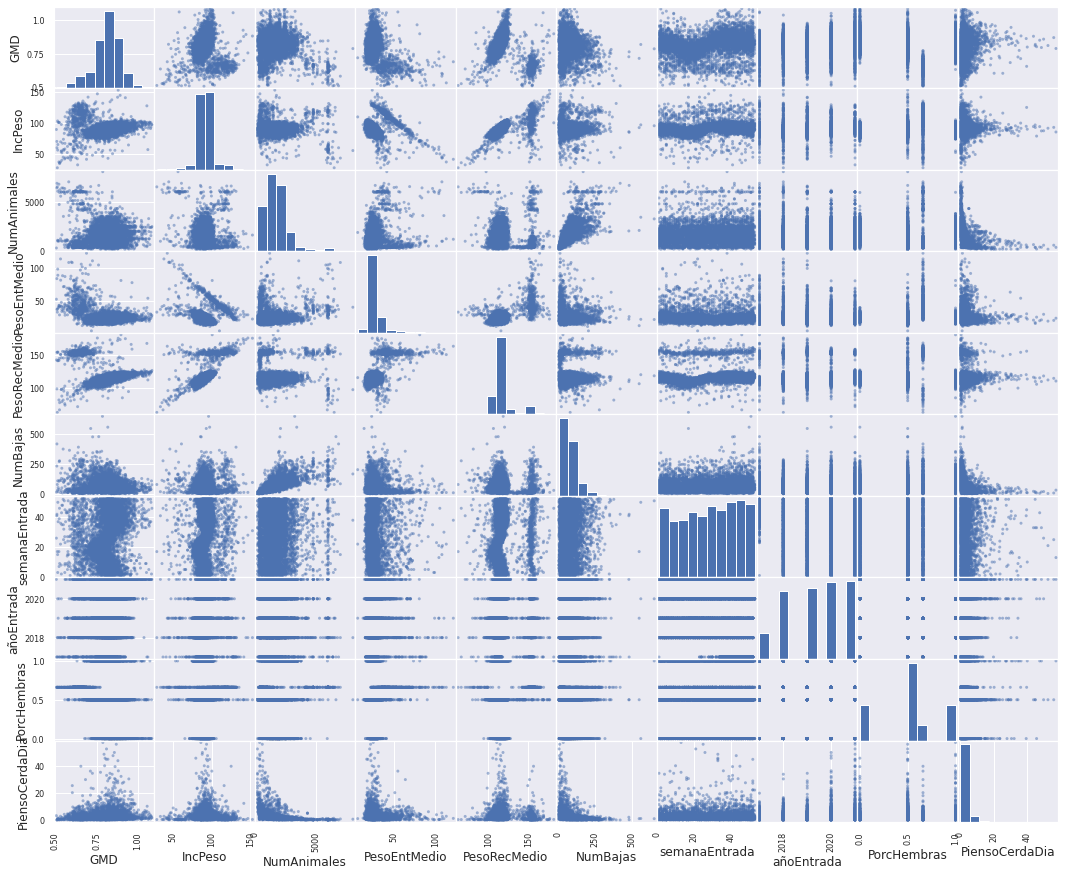

In [12]:
attributes = ['GMD', 'IncPeso', 'NumAnimales', 'PesoEntMedio', 'PesoRecMedio', 'NumBajas', 'semanaEntrada', 'añoEntrada', 'PorcHembras', 'PiensoCerdaDia']
pd.plotting.scatter_matrix(df[attributes], figsize=(18, 15))
plt.show()


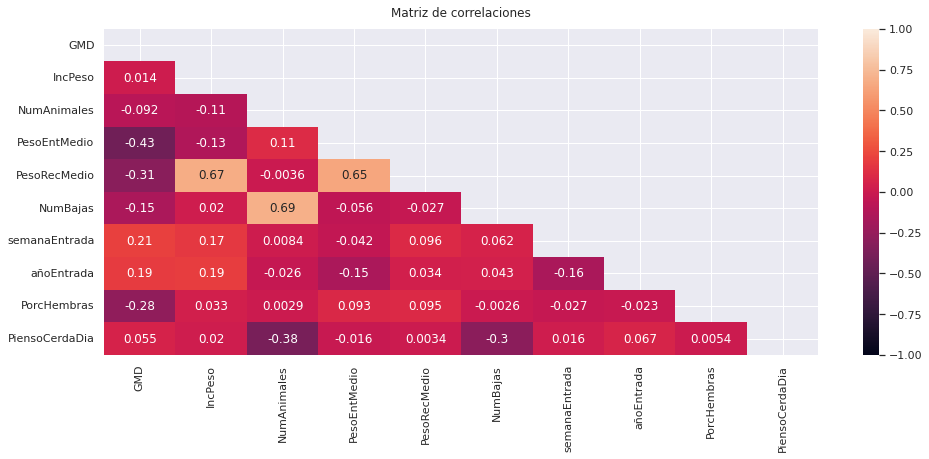

In [22]:
# Mostramos la matriz de correlaciones entre las principales variables.
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df[attributes].corr(), dtype=bool))
heatmap = sns.heatmap(df[attributes].corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Matriz de correlaciones', fontdict={'fontsize':12}, pad=12);
plt.show()

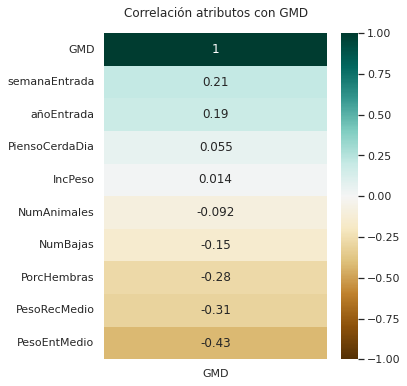

In [23]:
# Mostramos ordenadas las correlaciones de las variables con la variable Objetivo GMD.
plt.figure(figsize=(5, 6))
heatmap = sns.heatmap(df[attributes].corr()[['GMD']].sort_values(by='GMD', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlación atributos con GMD', fontdict={'fontsize':12}, pad=16);


## Dividir datos en entrenamiento y test

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x1, y, test_size = 0.2, random_state = 123)

## Escalar datos

In [29]:
## Vemos de escalar las variables para que no se vean influenciadas por los outliers.
scaler = RobustScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [32]:
# Mostramos las columnas usadas para entrenamiento y sus tipos.
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4221 entries, 3073 to 3582
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ct_tipo         4221 non-null   int64  
 1   IncPeso         4221 non-null   float64
 2   NumAnimales     4221 non-null   int64  
 3   PesoEntMedio    4221 non-null   float64
 4   PesoRecMedio    4221 non-null   float64
 5   NumBajas        4221 non-null   int64  
 6   GPS_Longitud    4221 non-null   float64
 7   GPS_Latitud     4221 non-null   float64
 8   semanaEntrada   4221 non-null   int64  
 9   añoEntrada      4221 non-null   int64  
 10  PorcHembras     4221 non-null   float64
 11  PiensoCerdaDia  4221 non-null   float64
 12  ct_raza_0       4221 non-null   uint8  
 13  ct_raza_7       4221 non-null   uint8  
 14  ct_raza_15      4221 non-null   uint8  
 15  ct_raza_69      4221 non-null   uint8  
 16  ct_raza_80      4221 non-null   uint8  
 17  ct_raza_81      4221 non-null 

# Modelo RandomForest

## Creación del modelo

In [35]:
rf = RandomForestRegressor(
            n_estimators = 100,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'sqrt',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )
rf.fit(X_train_s, y_train)

RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=123)

## Ver diferencias entre valor real y predicho en Test

In [36]:
# Función para Graficar diferencias entre valor predicho y real en datos de test del modelo pasado
def graficoDiferencias(modelo, X_test_s, y_test):
    y_pred = modelo.predict(X_test_s)
    diferencia = abs(y_pred - y_test)
    g = sns.jointplot(x=y_test, y=y_pred)
    # Draw a line of x=y
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, '-r')
    g.ax_joint.scatter(x=y_test, y=y_pred, c=diferencia.values, cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True))
    plt.show()

Score R2: 0.8374235261096492


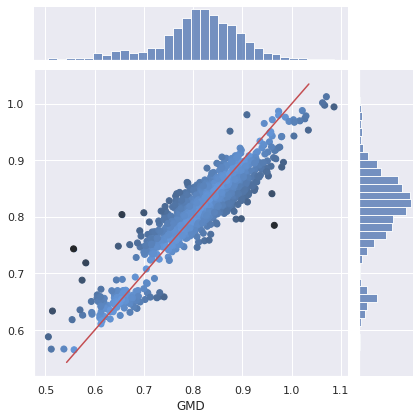

In [37]:
# Graficar las diferencias
print('Score R2:',rf.score(X_test_s, y_test))
graficoDiferencias(rf, X_test_s, y_test)

In [46]:
# Analizamos otros errores del método
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
y_pred = rf.predict(X_test_s)
# Definimos la función con las métricas a mostrar
def mostrar_metricas(y_test, y_pred):
   print("Metr.\t Valor\t\t\t Descripción")
   print("R^2 \t", r2_score(y_test, y_pred), "\t (Coeficiente de Determinación)")
   print("RMSE\t", mean_squared_error(y_test, y_pred, squared=True), "\t (Raíz de error cuadrático medio)")
   print("MAE \t", mean_absolute_error(y_test, y_pred), "\t (Error absoluto medio)")
   print("MAX \t", max_error(y_test, y_pred), "\t (Error Máximo)")
# Pedimos que muestre las métricas para el modelo de RandomForest
print("Métricas para RandomForest v1")
mostrar_metricas(y_test, y_pred)

Métricas para RandomForest v1
Metr.	 Valor			 Descripción
R^2 	 0.8374235261096492 	 (Coeficiente de Determinación)
RMSE	 0.0011649659546919778 	 (Raíz de error cuadrático medio)
MAE 	 0.026242195812343477 	 (Error absoluto medio)
MAX 	 0.1865646562229064 	 (Error Máximo)


## Variables más importantes según modelo

In [47]:
# Mostrar las variables más importantes
important_features_dict = {}
for idx, val in enumerate(rf.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict, key=important_features_dict.get, reverse=True)
print(f'Las 10 características más relevantes para la regresión son:')
print('\tOrden\tCaracterística\tImportancia')
for i in range(10):
    print('\t', i+1, '\t', x1.columns[important_features_list[i]], '\t', important_features_dict.get(important_features_list[i]))

Las 10 características más relevantes para la regresión son:
	Orden	Característica	Importancia
	 1 	 PesoRecMedio 	 0.21749210508581746
	 2 	 ct_tipo 	 0.12487164610062121
	 3 	 ct_raza_69 	 0.1187224454879094
	 4 	 PesoEntMedio 	 0.08517780638884401
	 5 	 IncPeso 	 0.07061634689681891
	 6 	 PorcHembras 	 0.0603831936601936
	 7 	 semanaEntrada 	 0.057552534846114375
	 8 	 ct_raza_93 	 0.043045171969281044
	 9 	 NumAnimales 	 0.04262664642379298
	 10 	 NumBajas 	 0.04256129306010047


## Optimización de Hiperparámetros
Intentamos ver hasta dónde se pueden optimizar los hiperparámetros haciendo uso de una búsqueda aleatoria entre una gran variadead de valores de esos hiperparámetros.

### Definir hiperparámetros a optimizar y con qué posibles valores

In [51]:
# Hago una optimización de los hiperparámetros para RandomForest
from sklearn.model_selection import RandomizedSearchCV
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': [1.0, 'sqrt', 2, 5, 10, 20],
               'min_samples_leaf': [1, 2, 4, 10],
               'min_samples_split': [2, 5, 10, 20],
               'n_estimators': [20, 50, 75, 100, 150, 250, 500]}


### Lanzar búsqueda de mejores parámetros

In [52]:
rf_random = RandomizedSearchCV(scoring="neg_mean_squared_error", estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=1, random_state=123, n_jobs = -1)
rf_random.fit(X_train_s, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(max_features='sqrt',
                                                   n_jobs=-1,
                                                   random_state=123),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [1.0, 'sqrt', 2, 5, 10,
                                                         20],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [20, 50, 75, 100, 150,
                                                         250, 500]},
                   random_state=123, scoring='neg_mean_squared_error',
                   verbose=1)

### Analizar mejor modelo y su error

In [53]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 5,
 'max_depth': None,
 'bootstrap': False}

Tras probar aleatoreamente entre 300 combinaciones del rango de hiperparámetros propuesto la mejor solución para optimizar el error cuadrático medio ha sido la que se muestra. La búsqueda de los mejores hiperparámetros tardó en Google Colab 25 minutos, probando las 300 combinaciones para 3 particiones de los datos cada una.

In [56]:
# Medimos las diferencias de la predicción para los valores de test (no usados en entrenamiento)
y_pred = rf_random.best_estimator_.predict(X_test_s)
mostrar_metricas(y_test, y_pred)

Metr.	 Valor			 Descripción
R^2 	 0.8423953775237745 	 (Coeficiente de Determinación)
RMSE	 0.0011293394123599698 	 (Raíz de error cuadrático medio)
MAE 	 0.025700864611127017 	 (Error absoluto medio)
MAX 	 0.1811238651158089 	 (Error Máximo)


El error obtenido es de tan sólo -0.001129...

Score R2: 0.8423953775237745


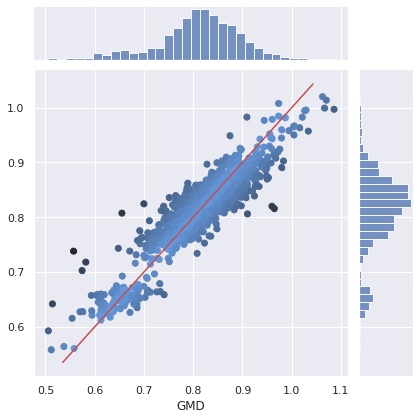

In [54]:
print('Score R2:',rf_random.best_estimator_.score(X_test_s, y_test))
graficoDiferencias(rf_random.best_estimator_, X_test_s, y_test)

Hemos obtenido un coeficiente de determinación de 84,24%, mejorando el de los parámetros iniciales en un 0,5%.

Si medimos las diferencias sobre el conjunto de datos de test (no usado en el entrenamiento), el error se mantiene similar al obtenido en la validación cruzada del modelo, por lo que parece que no está sobreajustado y generaliza correctamente.

# Estimar mejores modelos con LazzyPredict
La librería lazzypredict permite estimar los modelos que mejor representan nuestro modelo según una métrica dada, probando en más de 40 modelos y ofreciendo un ranking de los resultados. No ofrecen los mejores hiperparámetros para cada uno de esos modelos, pero es un buen punto de partida, para seleccionar los modelos más prometedores y realizar sobre ellos la optimización de hiperparámetros, con la que encontrar más rápidamente un buen modelo que se aproxime a la mejor solución disponible con los métodos y variables actuales.

In [49]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import lazypredict
from lazypredict.Supervised import LazyRegressor
# Borramos el modelo que tarda mucho
del lazypredict.Supervised.REGRESSORS[29:32]    # PassiveAggressiveRegressor, PoissonRegressor, QuantileRegressor
reg = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train_s, X_test_s, y_train, y_test)

print(models)

  3%|▎         | 1/39 [00:01<01:02,  1.65s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7383284945729855, 'Adjusted R-Squared': 0.7332720403618355, 'RMSE': 0.043301803342092736, 'Time taken': 1.6471836566925049}


  8%|▊         | 3/39 [00:02<00:26,  1.37it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.8208408837346853, 'Adjusted R-Squared': 0.8173788718261769, 'RMSE': 0.03583003419160197, 'Time taken': 0.98443603515625}
{'Model': 'BayesianRidge', 'R-Squared': 0.6877916424161634, 'Adjusted R-Squared': 0.6817586306754129, 'RMSE': 0.04729878982612764, 'Time taken': 0.09429216384887695}


 15%|█▌        | 6/39 [00:03<00:09,  3.61it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5968383972306224, 'Adjusted R-Squared': 0.5890478348582673, 'RMSE': 0.053748623735115145, 'Time taken': 0.1799788475036621}
{'Model': 'DummyRegressor', 'R-Squared': -0.00023142543513321456, 'Adjusted R-Squared': -0.01955956892180244, 'RMSE': 0.08465995131903602, 'Time taken': 0.05187559127807617}
{'Model': 'ElasticNet', 'R-Squared': -0.00023142543513321456, 'Adjusted R-Squared': -0.01955956892180244, 'RMSE': 0.08465995131903602, 'Time taken': 0.07033038139343262}


 18%|█▊        | 7/39 [00:03<00:11,  2.82it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.6881496760167918, 'Adjusted R-Squared': 0.682123582799725, 'RMSE': 0.04727166144624252, 'Time taken': 0.5542194843292236}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.6191433919497514, 'Adjusted R-Squared': 0.611783843968104, 'RMSE': 0.0522406430792712, 'Time taken': 0.08073019981384277}


 23%|██▎       | 9/39 [00:07<00:30,  1.02s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8456182185541995, 'Adjusted R-Squared': 0.842634995724329, 'RMSE': 0.03326027156551318, 'Time taken': 3.661449909210205}
{'Model': 'GammaRegressor', 'R-Squared': 0.5655548653751366, 'Adjusted R-Squared': 0.5571597903099217, 'RMSE': 0.055794994072486996, 'Time taken': 0.0829167366027832}


 28%|██▊       | 11/39 [00:18<01:15,  2.71s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -5.131247534831636, 'Adjusted R-Squared': -5.2497257480650985, 'RMSE': 0.2096052671948895, 'Time taken': 10.674478769302368}


 31%|███       | 12/39 [00:20<01:11,  2.63s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8241596869669391, 'Adjusted R-Squared': 0.8207618065218558, 'RMSE': 0.035496619148354065, 'Time taken': 2.358671188354492}


 33%|███▎      | 13/39 [00:25<01:21,  3.13s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8529358293932292, 'Adjusted R-Squared': 0.8500940096713592, 'RMSE': 0.03246244343082335, 'Time taken': 4.745702266693115}


 36%|███▌      | 14/39 [00:25<01:00,  2.43s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.6463101831042963, 'Adjusted R-Squared': 0.6394755972705629, 'RMSE': 0.050342994530257985, 'Time taken': 0.31545519828796387}


 38%|███▊      | 15/39 [00:25<00:44,  1.87s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7771696544455903, 'Adjusted R-Squared': 0.7728637540484036, 'RMSE': 0.03995902967506126, 'Time taken': 0.2853965759277344}


 41%|████      | 16/39 [00:30<01:03,  2.75s/it]

{'Model': 'KernelRidge', 'R-Squared': -91.35531248093388, 'Adjusted R-Squared': -93.13995620037223, 'RMSE': 0.8135021552383831, 'Time taken': 5.058777332305908}
{'Model': 'Lars', 'R-Squared': 0.6879456647216999, 'Adjusted R-Squared': 0.6819156292573849, 'RMSE': 0.04728712138870148, 'Time taken': 0.062044382095336914}


 46%|████▌     | 18/39 [00:31<00:33,  1.61s/it]

{'Model': 'LarsCV', 'R-Squared': 0.6881346700605122, 'Adjusted R-Squared': 0.6821082868732757, 'RMSE': 0.047272798767414206, 'Time taken': 0.23823261260986328}
{'Model': 'Lasso', 'R-Squared': -0.00023142543513321456, 'Adjusted R-Squared': -0.01955956892180244, 'RMSE': 0.08465995131903602, 'Time taken': 0.056653738021850586}


 51%|█████▏    | 20/39 [00:31<00:20,  1.10s/it]

{'Model': 'LassoCV', 'R-Squared': 0.6881242577985845, 'Adjusted R-Squared': 0.682097673408219, 'RMSE': 0.04727358791036666, 'Time taken': 0.5369081497192383}
{'Model': 'LassoLars', 'R-Squared': -0.00023142543513321456, 'Adjusted R-Squared': -0.01955956892180244, 'RMSE': 0.08465995131903602, 'Time taken': 0.08185577392578125}


 59%|█████▉    | 23/39 [00:32<00:10,  1.55it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.6881346700605122, 'Adjusted R-Squared': 0.6821082868732757, 'RMSE': 0.047272798767414206, 'Time taken': 0.25451016426086426}
{'Model': 'LassoLarsIC', 'R-Squared': 0.6879456647216999, 'Adjusted R-Squared': 0.6819156292573849, 'RMSE': 0.04728712138870148, 'Time taken': 0.12860631942749023}


 62%|██████▏   | 24/39 [00:32<00:08,  1.87it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.6868166367601418, 'Adjusted R-Squared': 0.6807647843303861, 'RMSE': 0.04737258772078065, 'Time taken': 0.1410818099975586}


 64%|██████▍   | 25/39 [00:33<00:09,  1.52it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.6208755797326792, 'Adjusted R-Squared': 0.6135495039787212, 'RMSE': 0.0521217089091026, 'Time taken': 1.0326433181762695}


 67%|██████▋   | 26/39 [00:35<00:13,  1.02s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.6386458653198789, 'Adjusted R-Squared': 0.6316631767270262, 'RMSE': 0.05088552750711731, 'Time taken': 2.050220012664795}


 74%|███████▍  | 29/39 [00:39<00:10,  1.09s/it]

{'Model': 'NuSVR', 'R-Squared': 0.8314842760063268, 'Adjusted R-Squared': 0.8282279335136954, 'RMSE': 0.03474945375853115, 'Time taken': 4.182615041732788}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5294344783992626, 'Adjusted R-Squared': 0.5203414248417604, 'RMSE': 0.05806812705734184, 'Time taken': 0.030356645584106445}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.6209229536716963, 'Adjusted R-Squared': 0.6135977933561734, 'RMSE': 0.05211845234256676, 'Time taken': 0.07910609245300293}


 77%|███████▋  | 30/39 [00:40<00:08,  1.02it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -7.108241972093151e+21, 'Adjusted R-Squared': -7.245599304887222e+21, 'RMSE': 7136887787.48085, 'Time taken': 0.6536555290222168}


 79%|███████▉  | 31/39 [00:44<00:14,  1.83s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8370206100633616, 'Adjusted R-Squared': 0.8338712498713492, 'RMSE': 0.03417386588716336, 'Time taken': 4.3172080516815186}
{'Model': 'Ridge', 'R-Squared': 0.6879270354147184, 'Adjusted R-Squared': 0.6818966399637951, 'RMSE': 0.047288532862688276, 'Time taken': 0.016965627670288086}
{'Model': 'RidgeCV', 'R-Squared': 0.6879270354158684, 'Adjusted R-Squared': 0.6818966399649673, 'RMSE': 0.04728853286260116, 'Time taken': 0.027530670166015625}
{'Model': 'SGDRegressor', 'R-Squared': 0.6875637700560175, 'Adjusted R-Squared': 0.6815263549846362, 'RMSE': 0.047316047725648055, 'Time taken': 0.03269052505493164}


 90%|████████▉ | 35/39 [00:45<00:03,  1.28it/s]

{'Model': 'SVR', 'R-Squared': 0.7045004255240367, 'Adjusted R-Squared': 0.6987902888191871, 'RMSE': 0.046015717350864356, 'Time taken': 0.15585851669311523}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.6868166367601418, 'Adjusted R-Squared': 0.6807647843303861, 'RMSE': 0.04737258772078065, 'Time taken': 0.021885156631469727}
{'Model': 'TweedieRegressor', 'R-Squared': 0.563278593442571, 'Adjusted R-Squared': 0.5548395324462922, 'RMSE': 0.05594097183054732, 'Time taken': 0.06086325645446777}


 97%|█████████▋| 38/39 [00:46<00:00,  1.59it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8457491009934, 'Adjusted R-Squared': 0.8427684072927893, 'RMSE': 0.03324616980926322, 'Time taken': 1.0528514385223389}


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.8529356325328594, 'Adjusted R-Squared': 0.8500938090069243, 'RMSE': 0.03246246515795938, 'Time taken': 0.2591981887817383}
                                      Adjusted R-Squared  \
Model                                                      
HistGradientBoostingRegressor                       0.85   
LGBMRegressor                                       0.85   
XGBRegressor                                        0.84   
ExtraTreesRegressor                                 0.84   
RandomForestRegressor                               0.83   
NuSVR                                               0.83   
GradientBoostingRegressor                           0.82   
BaggingRegressor                                    0.82   
KNeighborsRegressor                                 0.77   
AdaBoostRegressor                                   0.73   
SVR                                                 0.70   
ElasticNetCV                                        0.6